# Cloud composition profile
Trying to replicate a figure similar to Jenny's

In [11]:
from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

Set up directories based on where the program is being run from

In [12]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
model_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [13]:
all_cases = os.listdir('mnth15runs/')
all_cases

['20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

In [14]:
#specific_model = '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01.nc'
specific_model = '20191122_161009_sampleparamset_wbf_1_inp_1.nc'
#ct_val = '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01.nc'
case = specific_model[:-3]

run_dir = 'mnth15runs/%s/' % case # inconsistent label compared to jupy_test
#model_dir = 'NorESM_validation/%s' % ct_val
os.path.exists(run_dir)

True

In [23]:
relevant_vars = [
     'CLDFREE', 'CLDHGH','CLDICE', 'CLDLIQ', 'CLDLOW','CLDMED',
     'CLDTAU','CLDTOT','CLD_ISOTM','CLD_ISOTM_NONSIM','CLD_SLF',
     'CLD_SLF_NONSIM','CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
     'CONCLD', 'BERGO','BERGOXCLD_ISOTM','BERGOXCLD_ISOTM_NONSIM',
     'BERGSO','BERGSOXCLD_ISOTM','BERGSOXCLD_ISOTM_NONSIM',
     'MG_SADICE','MG_SADLIQ','MNUCCCO','MNUCCDO','MNUCCDOhet',
     'MNUCCRO','MNUCCTO','NUMICE','NUMLIQ','NUMRAI','NUMSNO',
     'N_AER','PRECIPBINOCC_CC','PRECIPBINOCC_CL','PRECIPBINOCC_CT',
     'PRECIPBINRATE_CC','PRECIPBINRATE_CL','PRECIPBINRATE_CT', 
     'SADICEXCLD_ISOTM','SADICEXCLD_ISOTM_NONSIM','SADLIQXCLD_ISOTM',
     'SADLIQXCLD_ISOTM_NONSIM','SLFXCLD_ISOTM','SLFXCLD_ISOTM_NONSIM',
     'TS','AQSNOW', 'AQRAIN'
    ]

In [24]:
model_dir

'mnth15runs/'

In [25]:
run_dir

'mnth15runs/20191122_161009_sampleparamset_wbf_1_inp_1/'

In [27]:
ds = xr.open_dataset('%s%s.nc' % (run_dir, case))

In [28]:
ds['CLDICE']

<xarray.DataArray 'CLDICE' (time: 15, lev: 32, lat: 96, lon: 144)>
[6635520 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0002-04-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:     Grid box averaged cloud ice amount
    units:         kg/kg
    mdims:         1
    cell_methods:  time: mean

In [29]:
# Load NorESM data
ds = xr.open_dataset('%s/%s.nc' % (run_dir,case))
if (len(ds['time']) > 1):
    ds = ds.sel(time=slice('0001-04-01', '0002-03-01')) # discard 3 months as wind-up
ds = add_weights(ds)

These variables are both in units of kg/kg. I'm not sure what 'equivalent' CALIOP value is.

In [33]:
cldvars = ds[['CLDICE', 'CLDLIQ']]

In [36]:
bands = {'Global':[-90,90],'Arctic':[66.667,90],'Antarctic':[-90,-66.667]}
df = pd.DataFrame()

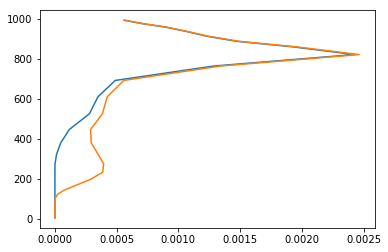

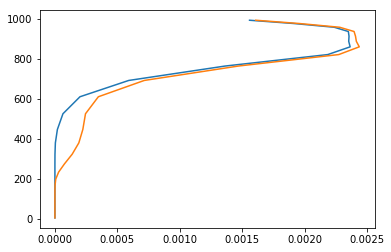

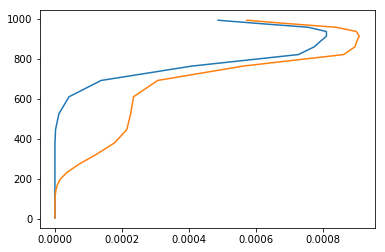

In [52]:
#df['isotherm'] = slf1['isotherm']
#df = df.set_index('isotherm')
for i in bands:
    _rng = bands[i]
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask2 = np.bitwise_or(ds['lat']<_rng[0], ds['lat']>_rng[1])
    
    weight1 = ds['cell_weight']
    
    cldice = 100*masked_average(ds['CLDICE'], dim=['lat','lon','time'],weights=weight1, mask=mask2)
    cldliq = 100*masked_average(ds['CLDLIQ'], dim=['lat','lon','time'],weights=weight1, mask=mask2)

    plt.figure()
    plt.plot(cldice, cldice['lev'])
    plt.plot(cldliq, cldliq['lev'])